AML - VOC 2012

Volpato Mattia 866316

## Imports and utility

In [ ]:
%pip install pympler

In [ ]:
colab=False

In [ ]:
if colab:
    from google.colab import drive

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import os
from pympler import asizeof

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

In [ ]:
RANDOM_STATE = 17
N_IMAGES_TO_SHOW = 10
N_CLASSES = 20
IMG_SIZE = (64, 64)#da 128x128

np.random.seed(RANDOM_STATE)
tf.random.set_seed(RANDOM_STATE)
keras.utils.set_random_seed(RANDOM_STATE)

In [ ]:
if colab:
    drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
if colab:
    ROOT_DIR = '/content/drive/MyDrive/'
    BASE_DIR = ROOT_DIR + 'project/dataset/compressed/'
else:
    BASE_DIR = '../dataset/compressed/'
BASE_DIR

'/content/drive/MyDrive/project/dataset/compressed/'

In [ ]:
TRAIN_PATH = BASE_DIR + 'train.npz'
VALIDATION_PATH = BASE_DIR + 'validation.npz'
TEST_PATH = BASE_DIR + 'test.npz'

TRAIN_PATH, VALIDATION_PATH, TEST_PATH

('/content/drive/MyDrive/project/dataset/compressed/train.npz',
 '/content/drive/MyDrive/project/dataset/compressed/validation.npz',
 '/content/drive/MyDrive/project/dataset/compressed/test.npz')

In [ ]:
def plot_history(history) -> None:
    metrics = list(history.history.keys())

    n_metrics = len([m for m in metrics if not m.startswith('val_')])
    n_cols = 2
    n_rows = (n_metrics + 1) // 2  # Arrotonda per eccesso

    fig, axis = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
    fig.tight_layout(pad=3.0)

    if n_rows > 1:
        axis = axis.flatten()

    plot_index = 0

    base_metrics = [m for m in metrics if not m.startswith('val_')]

    for metric in base_metrics:
        val_metric = f'val_{metric}'

        if metric not in history.history:
            continue

        train_data = history.history[metric]
        val_data = history.history[val_metric] if val_metric in history.history else None

        if n_rows > 1:
            current_axis = axis[plot_index]
        else:
            current_axis = axis[plot_index] if n_cols > 1 else axis

        current_axis.set_title(f'{metric.capitalize()}')
        current_axis.set_xlabel('Epochs')
        current_axis.set_ylabel(metric.capitalize())

        current_axis.plot(train_data, label=f'Training {metric.capitalize()}')
        if val_data is not None:
            current_axis.plot(val_data, label=f'Validation {metric.capitalize()}')

        current_axis.legend()

        plot_index += 1

    while plot_index < len(axis):
        fig.delaxes(axis[plot_index])
        plot_index += 1

    plt.show()

In [ ]:
@tf.keras.utils.register_keras_serializable()
def perfect_accuracy(y_true, y_pred, threshold=0.5):
    y_true = tf.cast(y_true, tf.uint8)
    y_pred_bin = tf.cast(y_pred >= threshold, tf.uint8)
    correct_predictions = tf.reduce_all(tf.equal(y_true, y_pred_bin), axis=1)
    return tf.reduce_mean(tf.cast(correct_predictions, tf.float32))

In [ ]:
CLASSES = [
    "aeroplane", "bicycle", "bird", "boat", "bottle", "bus", "car", "cat",
    "chair", "cow", "diningtable", "dog", "horse", "motorbike", "person",
    "pottedplant", "sheep", "sofa", "train", "tvmonitor"
]

classes_map = {c: i for i, c in enumerate(CLASSES)}
classes_map

{'aeroplane': 0,
 'bicycle': 1,
 'bird': 2,
 'boat': 3,
 'bottle': 4,
 'bus': 5,
 'car': 6,
 'cat': 7,
 'chair': 8,
 'cow': 9,
 'diningtable': 10,
 'dog': 11,
 'horse': 12,
 'motorbike': 13,
 'person': 14,
 'pottedplant': 15,
 'sheep': 16,
 'sofa': 17,
 'train': 18,
 'tvmonitor': 19}

In [ ]:
def vector_encoding(labels:list[int], num_classes:int):
    class_vector = np.zeros(num_classes)
    for label in labels:
      class_vector[classes_map[label]] = 1
    return class_vector

# Convert labels to one-hot encoding
def one_hot_encode(labels, num_classes):
    one_hot_labels = np.zeros((labels.size, num_classes))
    one_hot_labels[np.arange(labels.size), labels] = 1
    return one_hot_labels

In [ ]:
def preprocess_images(images: np.ndarray, resize=IMG_SIZE):
    images /= 255.0
    resized_images = []

    for i in range(images.shape[0]):
        resized_image = tf.image.resize(images[i], resize).numpy()
        resized_images.append(resized_image)

    resized_images = np.array(resized_images)
    del images

    return resized_images

## Loading and preprocessing

### Training set (rotated)

In [13]:
train_data = np.load(TRAIN_PATH, allow_pickle=True)
train_data

NpzFile '/content/drive/MyDrive/project/dataset/compressed/train.npz' with keys: images, labels

In [14]:
train_images = train_data['images']
train_images.shape

(9232, 227, 227, 3)

In [15]:
print(f'Size of train images before preprocessing: {asizeof.asizeof(train_images) / (1024**3)} GB')

Size of train images before preprocessing: 5.316537722945213 GB


Image preprocessing:

In [16]:
train_images = preprocess_images(train_images)
train_images.shape

(9232, 64, 64, 3)

In [17]:
print(f'Size of train images after preprocessing: {asizeof.asizeof(train_images) / (1024**3)} GB')

Size of train images after preprocessing: 0.42260758578777313 GB


In [18]:
from tqdm import tqdm

rotated_train=[]
rotated_train_y=[]
i=0
for i in tqdm(range(train_images.shape[0])):


    for j in range(4):
        if j==0:
            rotated = train_images[i]#not really rotated
        else:
            rotated = np.rot90(rotated)

        rotated_train.append(rotated)
        rotated_train_y.append(j)

train_labels = one_hot_encode(np.array(rotated_train_y), 4)
train_images = np.array(rotated_train)

rotated_train=0 #to free up space
print(train_images.shape)
print(train_labels.shape)

100%|██████████| 9232/9232 [00:00<00:00, 19448.35it/s]


(36928, 64, 64, 3)
(36928, 4)


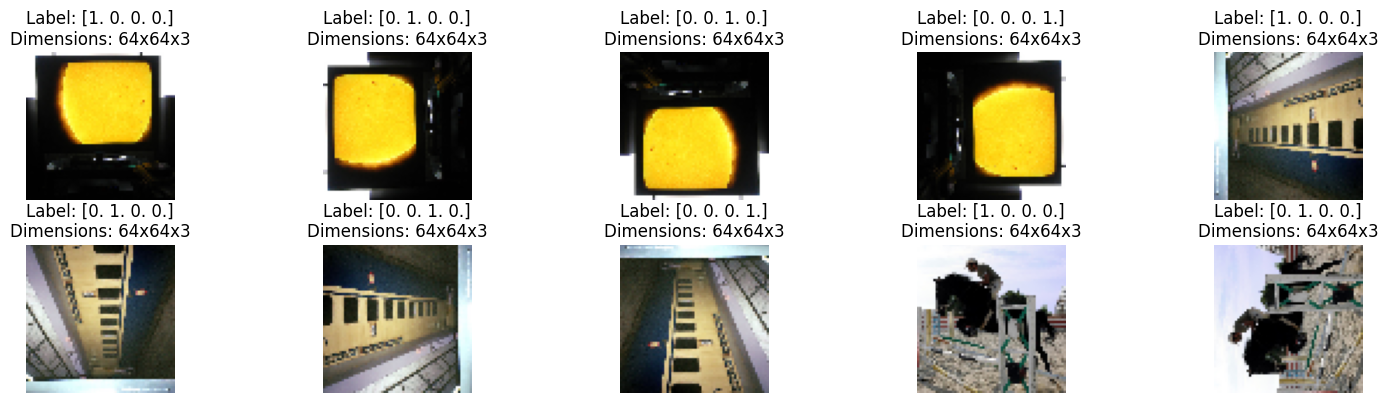

In [19]:
some_indices = range(N_IMAGES_TO_SHOW)
labels = [l for l in train_labels[some_indices]]
images = [i for i in train_images[some_indices]]

fig, axes = plt.subplots(2, len(images) // 2, figsize=(15, 4))
fig.tight_layout()

for i, axis in enumerate(axes.flat):
    axis.imshow(images[i])
    axis.axis('off')
    image_size = images[i].shape
    axis.set_title(f'Label: {labels[i]}\nDimensions: {image_size[0]}x{image_size[1]}x{image_size[2]}')

plt.show()

In [20]:
# Generate a random permutation of indices to shuffle once the data
shuffled_indices = np.random.permutation(len(train_labels))
train_labels = train_labels[shuffled_indices]
train_images = train_images[shuffled_indices]

### Validation set (rotated)

In [21]:
validation_data = np.load(VALIDATION_PATH, allow_pickle=True)
validation_data

NpzFile '/content/drive/MyDrive/project/dataset/compressed/validation.npz' with keys: images, labels

In [22]:
validation_images = validation_data['images']
validation_images.shape

(1154, 227, 227, 3)

In [23]:
print(f'Size of validation images before preprocessing: {asizeof.asizeof(validation_images) / (1024**3)} GB')

Size of validation images before preprocessing: 0.6645673587918282 GB


Image preprocessing:

In [24]:
validation_images = preprocess_images(validation_images)
validation_images.shape

(1154, 64, 64, 3)

In [25]:
print(f'Size of validation images after preprocessing: {asizeof.asizeof(validation_images) / (1024**3)} GB')

Size of validation images after preprocessing: 0.05282609164714813 GB


In [26]:
rotated_val=[]
rotated_val_y=[]
i=0
for i in tqdm(range(validation_images.shape[0])):


    for j in range(4):
        if j==0:
            rotated = validation_images[i]#not really rotated
        else:
            rotated = np.rot90(rotated)

        rotated_val.append(rotated)
        rotated_val_y.append(j)

validation_images = np.array(rotated_val)
validation_labels = one_hot_encode(np.array(rotated_val_y), 4)
rotated_val=0 #to free up space

100%|██████████| 1154/1154 [00:00<00:00, 30132.02it/s]


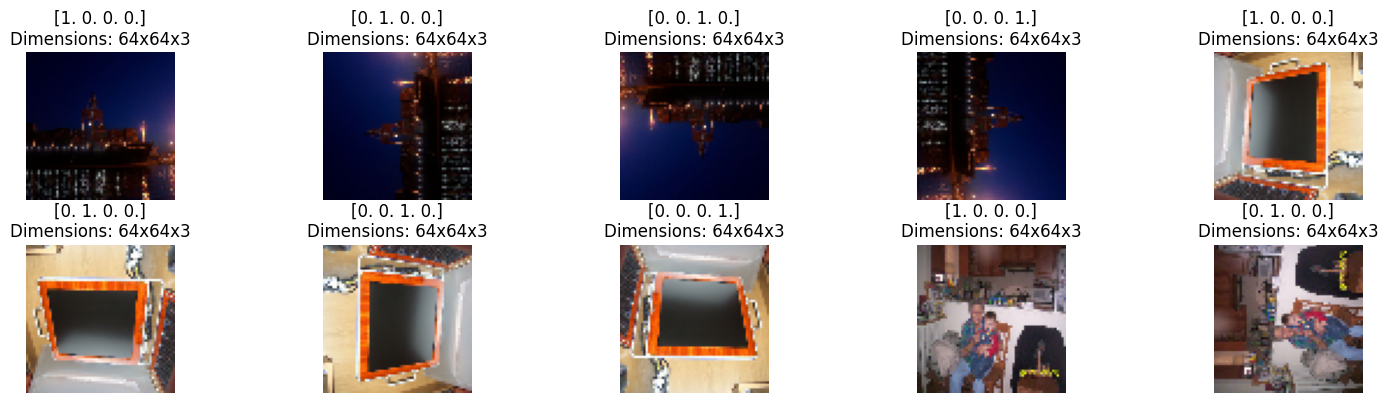

In [27]:
some_indices = range(N_IMAGES_TO_SHOW)
labels = [l for l in validation_labels[some_indices]]
images = [i for i in validation_images[some_indices]]

fig, axes = plt.subplots(2, len(images) // 2, figsize=(15, 4))
fig.tight_layout()

for i, axis in enumerate(axes.flat):
    axis.imshow(images[i])
    axis.axis('off')
    image_size = images[i].shape
    axis.set_title(f'{labels[i]}\nDimensions: {image_size[0]}x{image_size[1]}x{image_size[2]}')

plt.show()

## training the model on rotation classification task

In [28]:
from tensorflow.keras.metrics import AUC

def create_base_model(input_shape=(64, 64, 3), num_classes=4, dropout_rate=0.3, model_name="baseline_ssl_model", load_model=False):
    if load_model:
        return tf.keras.models.load_model(f"{model_name}.keras")


    model = models.Sequential([
        layers.Input(shape=input_shape),
        layers.Dropout(0.2),

        layers.Conv2D(32, (5, 5), kernel_initializer="HeNormal"),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(dropout_rate),

        layers.Conv2D(32, (5, 5), kernel_initializer="HeNormal"),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.Dropout(dropout_rate),

        layers.Conv2D(64, (3, 3), kernel_initializer="HeNormal"),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(dropout_rate),

        layers.Conv2D(64, (3, 3), kernel_initializer="HeNormal"),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.Dropout(dropout_rate),

        layers.Conv2D(64, (3, 3), kernel_initializer="HeNormal"),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.Dropout(dropout_rate),

        layers.Conv2D(64, (3, 3), kernel_initializer="HeNormal"),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.Dropout(dropout_rate),

        layers.Flatten(),
        layers.Dense(32, activation='relu', kernel_initializer="HeNormal"),
        layers.Dropout(0.5),

        layers.Dense(num_classes, activation='sigmoid')
    ], name=model_name)

    # Mean Average Precision (mAP) usando AUC con curva Precision-Recall
    map_metric = AUC(
        curve='PR',  # Precision-Recall curve
        multi_label=True,
        name='mAP'
    )

    f1 = tf.keras.metrics.F1Score(
        average="weighted",
        name='f1_score'
    )

    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=[
            perfect_accuracy,
            f1,
            map_metric
        ]
    )

    return model

model = create_base_model(input_shape=(64, 64, 3))
model.summary()

Model: "baseline_ssl_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dropout (Dropout)                    │ (None, 64, 64, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 60, 60, 32)          │           2,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 60, 60, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 60, 60, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 30, 30, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 30, 30, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 26, 26, 32)          │          25,632 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 26, 26, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 26, 26, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 26, 26, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 24, 24, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 24, 24, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 24, 24, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 12, 12, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 12, 12, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 10, 10, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 10, 10, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_3 (Activation)            │ (None, 10, 10, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 10, 10, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 232,516 (908.27 KB)

 Trainable params: 231,876 (905.77 KB)

 Non-trainable params: 640 (2.50 KB)

In [43]:
early_stopping = EarlyStopping(monitor='val_f1_score', patience=30, restore_best_weights=True)
early_stopping

In [42]:
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath='baseline_ssl_model_epoch_{epoch:02d}.keras',
    monitor='val_f1_score',
    mode='max',
    save_freq='epoch',
    save_best_only=True
    )

In [31]:
print(train_images.shape)
print(train_labels.shape)
print(validation_images.shape)
print(validation_labels.shape)

(36928, 64, 64, 3)
(36928, 4)
(4616, 64, 64, 3)
(4616, 4)


In [32]:
history = model.fit(
    train_images,
    train_labels,
    validation_data=(validation_images, validation_labels),
    epochs=500,
    callbacks=[early_stopping, model_checkpoint]
)

Epoch 1/500
1154/1154 ━━━━━━━━━━━━━━━━━━━━ 37s 16ms/step - f1_score: 0.3239 - loss: 0.5860 - mAP: 0.3133 - perfect_accuracy: 0.0696 - val_f1_score: 0.1720 - val_loss: 0.5598 - val_mAP: 0.3855 - val_perfect_accuracy: 0.0034
Epoch 2/500
1154/1154 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - f1_score: 0.3966 - loss: 0.5263 - mAP: 0.4359 - perfect_accuracy: 0.1403 - val_f1_score: 0.3732 - val_loss: 0.5332 - val_mAP: 0.4560 - val_perfect_accuracy: 0.0377
Epoch 3/500
1154/1154 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - f1_score: 0.4242 - loss: 0.5094 - mAP: 0.4761 - perfect_accuracy: 0.1614 - val_f1_score: 0.4241 - val_loss: 0.5286 - val_mAP: 0.4900 - val_perfect_accuracy: 0.0265
Epoch 4/500
1154/1154 ━━━━━━━━━━━━━━━━━━━━ 21s 10ms/step - f1_score: 0.4351 - loss: 0.5039 - mAP: 0.4897 - perfect_accuracy: 0.1759 - val_f1_score: 0.4119 - val_loss: 0.5299 - val_mAP: 0.4816 - val_perfect_accuracy: 0.0205
Epoch 5/500
1154/1154 ━━━━━━━━━━━━━━━━━━━━ 20s 9ms/step - f1_score: 0.4409 - loss: 0.5004 - mAP: 0.4966 - perf

In [33]:
model.save(f"{model.name}.keras")

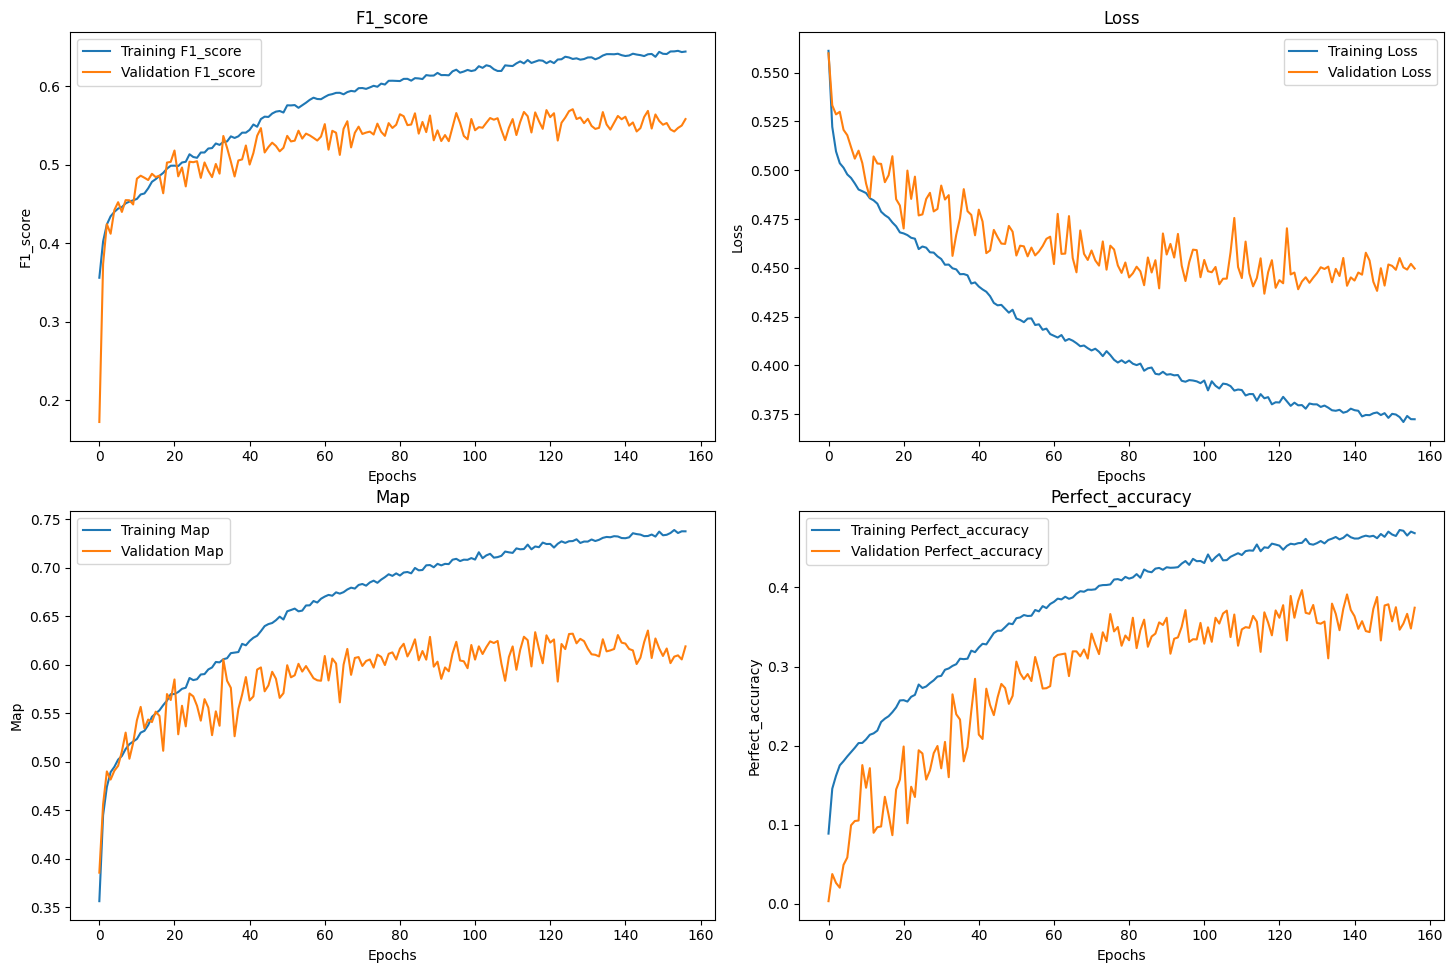

In [34]:
plot_history(history)

# Loading raw photos and finetuning

## Training set

In [13]:
train_data = np.load(TRAIN_PATH, allow_pickle=True)
train_data

NpzFile '/content/drive/MyDrive/project/dataset/compressed/train.npz' with keys: images, labels

In [14]:
train_images = train_data['images']
train_images.shape

(9232, 227, 227, 3)

In [15]:
print(f'Size of train images before preprocessing: {asizeof.asizeof(train_images) / (1024**3)} GB')

Size of train images before preprocessing: 5.316537722945213 GB


Image preprocessing:

In [16]:
train_images = preprocess_images(train_images)
train_images.shape

(9232, 64, 64, 3)

In [17]:
print(f'Size of train images after preprocessing: {asizeof.asizeof(train_images) / (1024**3)} GB')

Size of train images after preprocessing: 0.42260758578777313 GB


Labels encoding:

In [18]:
train_labels = train_data['labels']
train_labels.shape

(9232,)

In [19]:
print(f'Size of train labels before encoding: {asizeof.asizeof(train_labels) / (1024**2)} MB')

Size of train labels before encoding: 0.0706024169921875 MB


In [20]:
encoded_train_labels = np.array([vector_encoding(l, N_CLASSES) for l in train_labels])
encoded_train_labels.shape, encoded_train_labels[0], train_labels[0]

((9232, 20),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 1.]),
 ['tvmonitor'])

In [21]:
print(f'Size of train labels after encoding: {asizeof.asizeof(train_labels) / (1024**2)} MB')

Size of train labels after encoding: 0.0706024169921875 MB


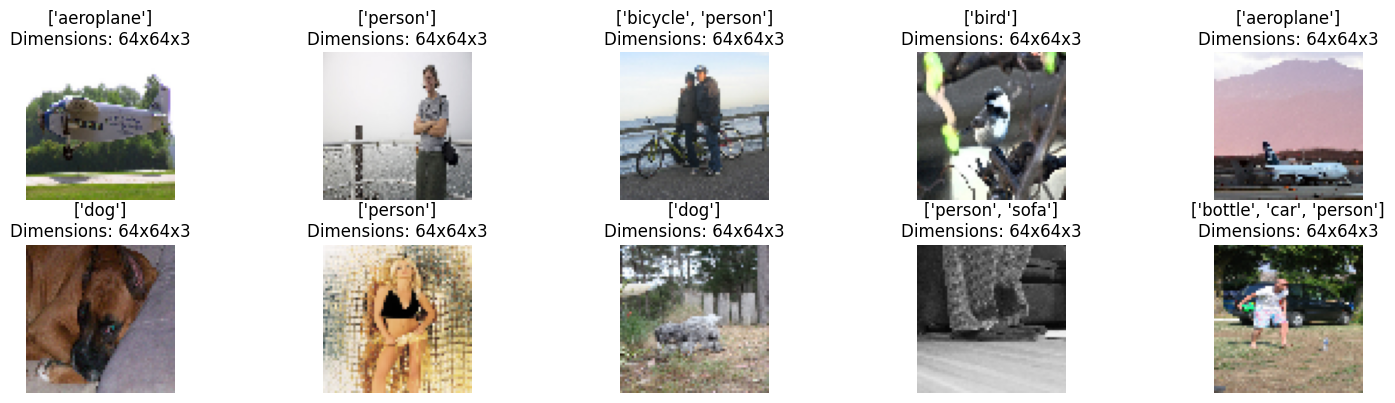

In [22]:
np.random.seed(RANDOM_STATE)
random_indices = np.random.choice(train_images.shape[0], size=N_IMAGES_TO_SHOW, replace=False)
labels = [l for l in train_labels[random_indices]]
images = [i for i in train_images[random_indices]]

fig, axes = plt.subplots(2, len(images) // 2, figsize=(15, 4))
fig.tight_layout()

for i, axis in enumerate(axes.flat):
    axis.imshow(images[i])
    axis.axis('off')
    image_size = images[i].shape
    axis.set_title(f'{labels[i]}\nDimensions: {image_size[0]}x{image_size[1]}x{image_size[2]}')

plt.show()

## Validation set

In [23]:
validation_data = np.load(VALIDATION_PATH, allow_pickle=True)
validation_data

NpzFile '/content/drive/MyDrive/project/dataset/compressed/validation.npz' with keys: images, labels

In [24]:
validation_images = validation_data['images']
validation_images.shape

(1154, 227, 227, 3)

In [25]:
print(f'Size of validation images before preprocessing: {asizeof.asizeof(validation_images) / (1024**3)} GB')

Size of validation images before preprocessing: 0.6645673587918282 GB


Image preprocessing:

In [26]:
validation_images = preprocess_images(validation_images)
validation_images.shape

(1154, 64, 64, 3)

In [27]:
print(f'Size of validation images after preprocessing: {asizeof.asizeof(validation_images) / (1024**3)} GB')

Size of validation images after preprocessing: 0.05282609164714813 GB


Labels encoding:

In [28]:
validation_labels = validation_data['labels']
validation_labels.shape

(1154,)

In [29]:
encoded_validation_labels = np.array([vector_encoding(l, N_CLASSES) for l in validation_labels])
encoded_validation_labels.shape, encoded_validation_labels[0], validation_labels[0]

((1154, 20),
 array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0.]),
 ['boat'])

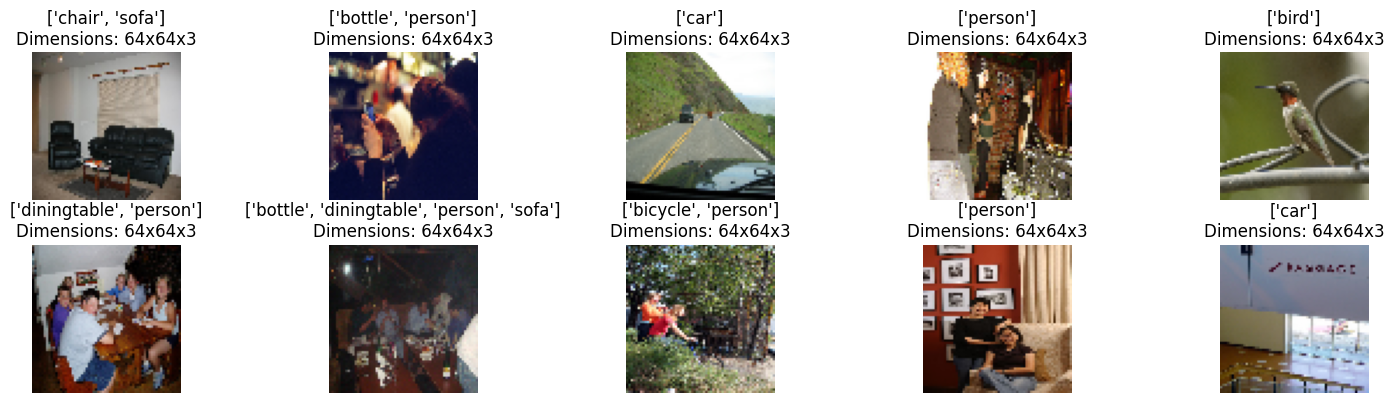

In [30]:
np.random.seed(RANDOM_STATE)
random_indices = np.random.choice(validation_images.shape[0], size=N_IMAGES_TO_SHOW, replace=False)
labels = [l for l in validation_labels[random_indices]]
images = [i for i in validation_images[random_indices]]

fig, axes = plt.subplots(2, len(images) // 2, figsize=(15, 4))
fig.tight_layout()

for i, axis in enumerate(axes.flat):
    axis.imshow(images[i])
    axis.axis('off')
    image_size = images[i].shape
    axis.set_title(f'{labels[i]}\nDimensions: {image_size[0]}x{image_size[1]}x{image_size[2]}')

plt.show()

## supervised finetuning

In [34]:
from tensorflow.keras.models import load_model
model = load_model("baseline_ssl_model.keras")

In [35]:
from tensorflow.keras.metrics import AUC

for layer in model.layers:
    layer.trainable=False

model.pop()
model.add(layers.Dense(20, activation='sigmoid') )

model.layers[-1].trainable=True
model.layers[-2].trainable=True
model.layers[-3].trainable=True
model.layers[-4].trainable=True

#model.layers[-1] = layers.Dense(20, activation='sigmoid')


# Mean Average Precision (mAP) usando AUC con curva Precision-Recall
map_metric = AUC(
    curve='PR',  # Precision-Recall curve
    multi_label=True,
    name='mAP'
)

f1 = tf.keras.metrics.F1Score(
    average="weighted",
    name='f1_score',
    threshold=0.5
)

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=[
        perfect_accuracy,
        f1,
        map_metric
]
)


# Fix possible problems with new model
model.save('temp.keras')
model = tf.keras.models.load_model('temp.keras')


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 10 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [37]:
encoded_validation_labels.shape

(1154, 20)

In [43]:
early_stopping = EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True)
early_stopping

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath='baseline_ssl_model_epoch_{epoch:02d}.keras',
    monitor='val_loss',
    mode='min',
    save_freq='epoch',
    save_best_only=True
    )

In [44]:
history = model.fit(
    train_images,
    encoded_train_labels,
    validation_data=(validation_images, encoded_validation_labels),
    epochs=500,
    callbacks=[early_stopping, model_checkpoint]
)

Epoch 1/500
289/289 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - f1_score: 0.0174 - loss: 0.3389 - mAP: 0.0756 - perfect_accuracy: 0.0020 - val_f1_score: 0.0012 - val_loss: 0.2543 - val_mAP: 0.0806 - val_perfect_accuracy: 0.0000e+00
Epoch 2/500
289/289 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - f1_score: 0.0073 - loss: 0.3036 - mAP: 0.0772 - perfect_accuracy: 5.7613e-04 - val_f1_score: 0.0000e+00 - val_loss: 0.2503 - val_mAP: 0.0859 - val_perfect_accuracy: 0.0000e+00
Epoch 3/500
289/289 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - f1_score: 0.0034 - loss: 0.2880 - mAP: 0.0766 - perfect_accuracy: 4.3810e-04 - val_f1_score: 0.0000e+00 - val_loss: 0.2475 - val_mAP: 0.0880 - val_perfect_accuracy: 0.0000e+00
Epoch 4/500
289/289 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - f1_score: 0.0016 - loss: 0.2750 - mAP: 0.0789 - perfect_accuracy: 3.0217e-04 - val_f1_score: 0.0000e+00 - val_loss: 0.2445 - val_mAP: 0.0952 - val_perfect_accuracy: 0.0000e+00
Epoch 5/500
289/289 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - f1_score: 0.0043 - loss: 0.26

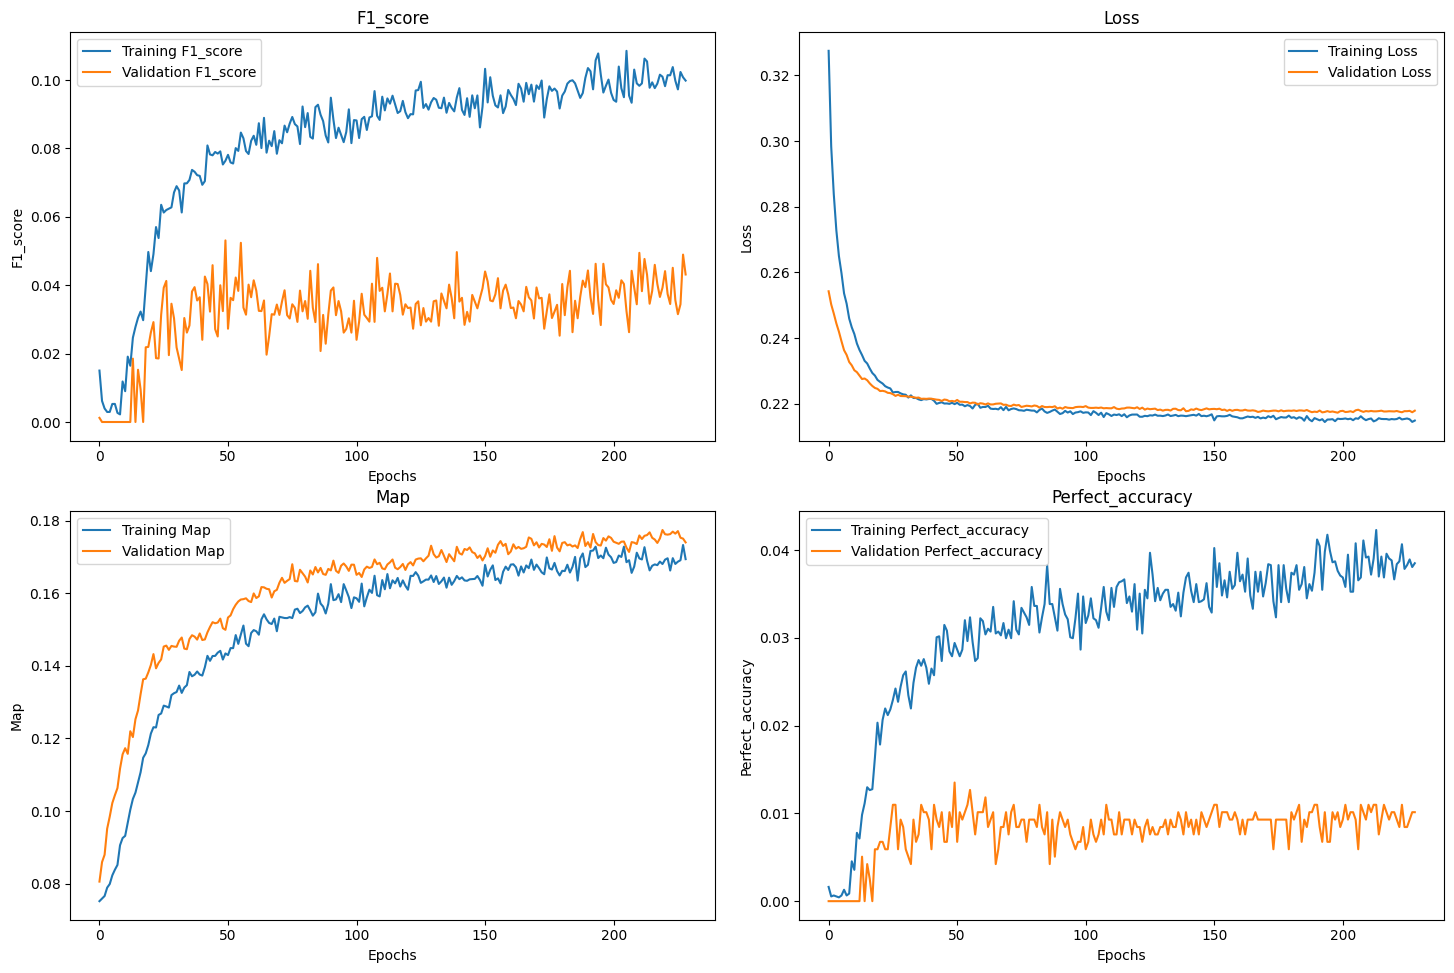

In [45]:
plot_history(history)

In [46]:
model.save(f"{model.name}_finetuned.keras")

# Test

### loading Test set

In [47]:
test_data = np.load(TEST_PATH, allow_pickle=True)
test_data

NpzFile '/content/drive/MyDrive/project/dataset/compressed/test.npz' with keys: images, labels

In [48]:
test_images = test_data['images']
test_images.shape

(1154, 227, 227, 3)

In [49]:
print(f'Size of test images before preprocessing: {asizeof.asizeof(test_images) / (1024**3)} GB')

Size of test images before preprocessing: 0.6645673587918282 GB


Image preprocessing:

In [50]:
test_images = preprocess_images(test_images)
test_images.shape

(1154, 64, 64, 3)

In [51]:
print(f'Size of test images after preprocessing: {asizeof.asizeof(test_images) / (1024**3)} GB')

Size of test images after preprocessing: 0.05282609164714813 GB


Labels encoding:

In [52]:
test_labels = test_data['labels']
test_labels.shape

(1154,)

In [53]:
encoded_test_labels = np.array([vector_encoding(l, N_CLASSES) for l in test_labels])
encoded_test_labels.shape, encoded_test_labels[0], test_labels[0]

((1154, 20),
 array([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
        0., 0., 1.]),
 ['bottle', 'person', 'tvmonitor'])

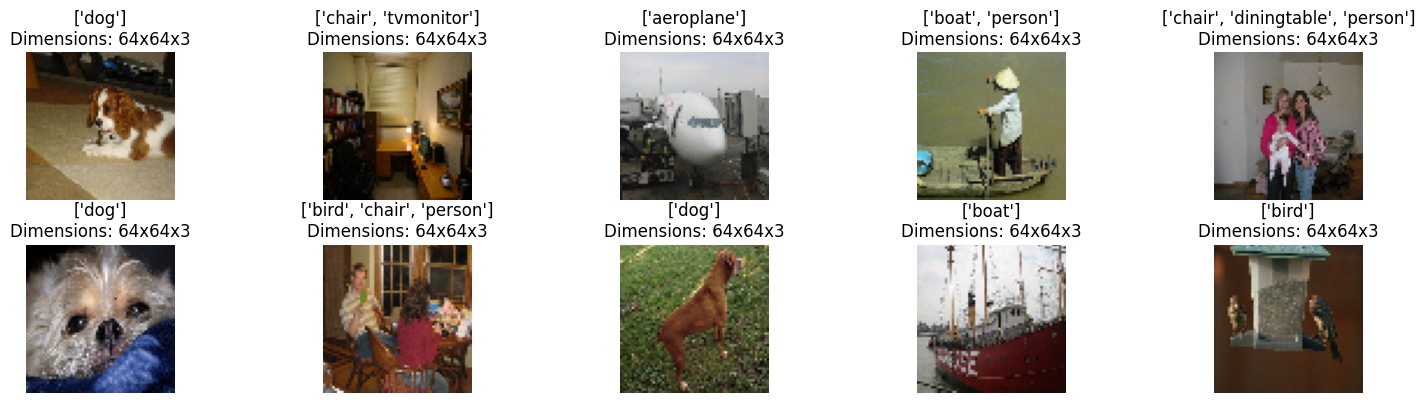

In [54]:
np.random.seed(RANDOM_STATE)
random_indices = np.random.choice(test_images.shape[0], size=N_IMAGES_TO_SHOW, replace=False)
labels = [l for l in test_labels[random_indices]]
images = [i for i in test_images[random_indices]]

fig, axes = plt.subplots(2, len(images) // 2, figsize=(15, 4))
fig.tight_layout()

for i, axis in enumerate(axes.flat):
    axis.imshow(images[i])
    axis.axis('off')
    image_size = images[i].shape
    axis.set_title(f'{labels[i]}\nDimensions: {image_size[0]}x{image_size[1]}x{image_size[2]}')

plt.show()

## determining best decision treshold

37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step


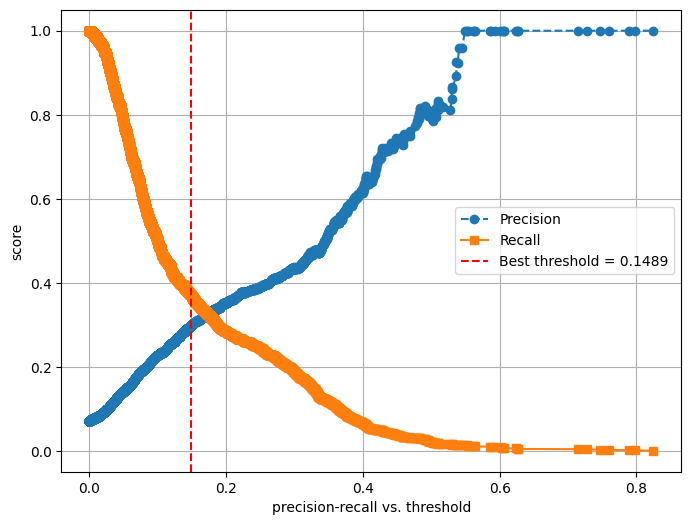

0.14887375

In [55]:
from sklearn.metrics import precision_recall_curve

y_pred_probs = model.predict(validation_images)

precisions, recalls, thresholds = precision_recall_curve(
    encoded_validation_labels.flatten(), y_pred_probs.flatten()
)

best_threshold = thresholds[np.argmax((precisions * recalls)/(precisions+recalls))]

plt.figure(figsize=(8, 6))
plt.plot(thresholds, precisions[:-1], label="Precision", linestyle='--', marker='o')
plt.plot(thresholds, recalls[:-1], label="Recall", linestyle='-', marker='s')

plt.axvline(x=best_threshold, color='r',linestyle='--',label=f"Best threshold = {best_threshold:.4f}")

plt.xlabel("threshold")
plt.ylabel("score")
plt.xlabel("precision-recall vs. threshold")
plt.legend()
plt.grid()
plt.show()

best_threshold

## predict on testset

In [69]:
y_pred = model.predict(test_images)
y_pred

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


array([[4.19490859e-02, 4.23091799e-02, 3.71810049e-02, ...,
        7.64387771e-02, 5.60193248e-02, 1.04249775e-01],
       [8.87690403e-05, 8.88054166e-03, 2.66442131e-02, ...,
        1.46494685e-02, 3.32148280e-04, 9.82571300e-03],
       [3.18689644e-02, 2.06959825e-02, 6.39846548e-02, ...,
        6.71085045e-02, 1.59736853e-02, 5.27556576e-02],
       ...,
       [6.63292482e-02, 4.32719104e-02, 8.57976973e-02, ...,
        2.51576472e-02, 3.73619609e-02, 1.94099117e-02],
       [3.58356833e-02, 3.67421769e-02, 1.77069902e-02, ...,
        5.04228808e-02, 6.33867681e-02, 9.51061472e-02],
       [6.41257986e-02, 6.52553290e-02, 7.23799393e-02, ...,
        4.08091992e-02, 7.56139010e-02, 5.05687557e-02]], dtype=float32)

In [70]:
thresholded = (y_pred>best_threshold).astype(int)

In [71]:
acc = perfect_accuracy(encoded_test_labels, thresholded) #equals to : acc = perfect_accuracy(encoded_test_labels[:320], y_pred_probs, threshold=best_threshold)
acc.numpy()

0.0372617

In [72]:

f1_metric = tf.keras.metrics.F1Score(
    average="weighted",
    name='f1_score',
    threshold=1.0*best_threshold #cast
)
f1_metric.update_state(encoded_test_labels, y_pred)
f1_metric.result().numpy()

0.22299689

In [73]:
map_metric = tf.keras.metrics.AUC(
    curve='PR',
    multi_label=True
)

map_metric.update_state(encoded_test_labels, y_pred)
map_metric.result().numpy()

0.19707492

In [74]:
metrics = {
    'perfect Accuracy': acc.numpy(),
    'F1': f1_metric.result().numpy(),
    'mAP': map_metric.result().numpy()
}

metrics

{'perfect Accuracy': 0.0372617, 'F1': 0.22299689, 'mAP': 0.19707492}